# Cancer Type Classification using Deep-Learning
## S.Ravichandran

This document will explain how to use genomic expression data for classifying different cancer/tumor sites/types. This workshop is a follow-up to the NCI-DOE Pilot1 benchmark also called TC1. You can read about the project here, https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/TC1

For classification, we use a Deep-Learning procedure called 1D-Convolutional Neural Network (CONV1D; https://en.wikipedia.org/wiki/Convolutional_neural_network. 
NCI Genomic Data Commons (GDC; https://gdc.cancer.gov/) is the source of RNASeq expression data. 

First we will start with genomic data preparation and then we will show how to use the data to build CONV1D model that can classify different cancer types. Please note that there are more than ways to extract data from GDC. What I am describing is one possible way. 

# Part-1: Genomic data preparation 

## Load some libraries

In [1]:
from __future__ import print_function
import os, warnings 
import sys 
import gzip
import glob
import json
import time 
import argparse
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from IPython.core.display import Image

from pandas.io.json import json_normalize
from keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
warnings.filterwarnings("ignore")

Using TensorFlow backend.
C:\Users\ravichandrans\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ravichandrans\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ravichandrans\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (t

## What type of data we need and where can we get it?

* We will be using RNASeq data 
* Genomic Data Commons ( www.gdc.org ) is the data source.
* We used FPKM-UQ scaled RNASeq expression data for tumor cases. Check here for information on scaling, https://docs.gdc.cancer.gov/Encyclopedia/pages/HTSeq-FPKM-UQ

## List of data preparation steps

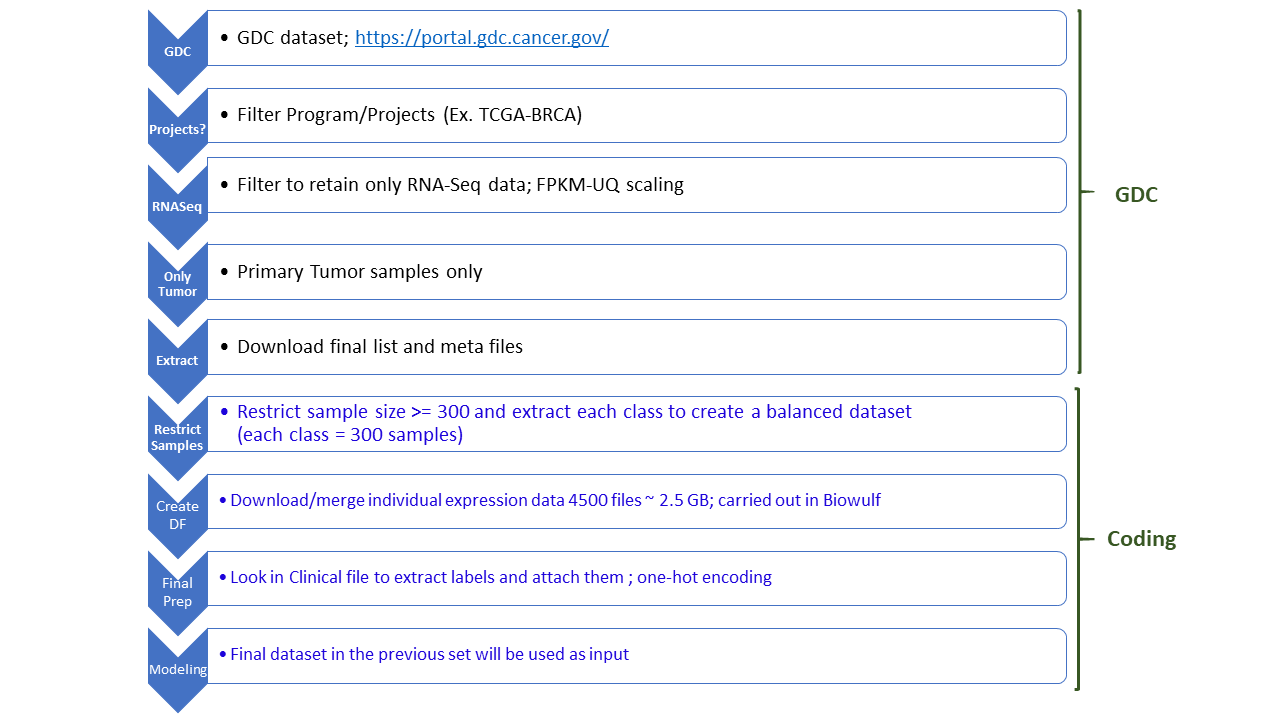

In [2]:
Image(filename='Img/OverallProcedure.png')

## Data gathering from GDC

Follow GDC tutorial, https://docs.gdc.cancer.gov/Data_Portal/Users_Guide/Getting_Started/, for information about how to download data. Here is a rough procedure: 

* search for projects of your interest (BRCA from TCGA, non-tumor samples etc.)
* filter the type of data you need (RNASeq, mutation etc)
* add it to Cart 
* download files relevant to your data (Manifest file (contain ids of the data that you want to download), meta data, clinical data etc.) 
 
You can use GDC tool, gdc-client, to download the data. Please, read details about gdc-clieant from the GDC website, https://docs.gdc.cancer.gov/Data_Transfer_Tool/Users_Guide/Data_Download_and_Upload/. For this tutorial, I will be using a GDC RNASeq tool (https://github.com/cpreid2/gdc-rnaseq-tool) that will download the GDC expression data and merge the expression files into one single dataframe.

NIH Biowulf HPC systems have access to gdc-tools. Please read for details here, https://hpc.nih.gov/apps/gdc-client.html 


## Manual data gathering steps from GDC

Please [click here](Supp-files/DataPreparation.md) to see the steps for exploring RNAseq expression data

## Genomic data is complex 

Due to complexity of the data, the expression and meta data are kept in different files 
For example, MetaData, SampleSheet, Manifest etc. 

#### Let us explore Metadata, Clinical, Biospecimen, Manifest and sample_sheet data 

Please note that the following files are available for each GDC search. You can access them by first adding the data to the Cart. Let us read the following files:

* **Manifest (list of RNASeq data for download):** gdc_manifest_20200309_162520.txt
* **Metadata data:** metadata.cart.2020-03-09.json
* **Clinical data:** clinical.cart.2020-03-09.json
* **Biospecimen data:** biospecimen.cart.2020-03-09.json (**131 MB; due to Github files size limit, this file is not available in the repository**)
* **Sample_sheet data:** gdc_sample_sheet.2020-03-09.tsv


In [3]:
gdc_manifest = pd.read_csv("Data/gdc_manifest_20200309_162520.txt", sep="\t", low_memory=False)
print("gdc_manifest")
gdc_manifest.iloc[0:4,0:3]

gdc_manifest


,id,filename,md5
0,00086b37-ad3a-4e4b-b44d-ea0cc657f48b,bdc49eae-31d4-425b-b7d1-49f1cf14df44.FPKM-UQ.t...,a26913ae01c41c8a69661573f201df88
1,000cf9c6-1373-4fb0-b759-5fd8c3799030,b9e7b7b5-54e8-4459-8a21-ea3472b013d7.FPKM-UQ.t...,6d41923b59f979df27888573ecaf8eaf
2,000e76af-9529-4e0b-b300-c602f5f717d2,b836a8d2-7c37-4af5-9f2f-7bf0121717f9.FPKM-UQ.t...,9e947e256131eee23678eb4e37a25c39
3,0012eb83-a0ab-4abe-bd9b-8706d613ad9c,42489a2e-a77b-43e2-a51e-dc341af3ae19.FPKM-UQ.t...,a41f8e12aef9dcb10113170eb4d6c89e


In [4]:
metadata = pd.read_json("Data/metadata.cart.2020-03-09.json", encoding='utf-8')
print("metadata")
metadata.iloc[0:3, [0,3,4]]

metadata


,file_name,data_type,file_id
0,d1b25b91-db55-4c0a-a973-2a6c229c2b03.FPKM-UQ.t...,Gene Expression Quantification,d8d316fd-0c47-48ce-9ee0-e41b6f96fcc6
1,875c2a27-9732-4b8a-affc-8ea591595a43.FPKM-UQ.t...,Gene Expression Quantification,f4885085-7300-4623-b7cd-3afd10808815
2,35c4cc14-5096-4da8-9190-359338fdb365.FPKM-UQ.t...,Gene Expression Quantification,90b463e6-d18a-4907-a427-ecc054dabb11


In [5]:
clinical = pd.read_json("Data/clinical.cart.2020-03-09.json", encoding='utf-8')
print("clinical data")
clinical.iloc[0:3, [0,2,3]]

clinical data


,diagnoses,case_id,demographic
0,"[{'ajcc_pathologic_t': 'T3a', 'synchronous_mal...",5338d435-68fb-4f0d-a3e6-c843f703f75f,"{'gender': 'male', 'vital_status': 'Alive', 'u..."
1,"[{'ajcc_pathologic_t': 'T1b', 'synchronous_mal...",22b6724c-a59f-4796-8166-992253e8caf1,"{'gender': 'male', 'vital_status': 'Alive', 'u..."
2,"[{'ajcc_clinical_t': 'T2c', 'ajcc_pathologic_t...",deceb7df-6edc-41f0-99aa-c4ac7e764074,"{'gender': 'male', 'vital_status': 'Alive', 'u..."


In [6]:
# biospecimen = pd.read_json("Data/biospecimen.cart.2020-03-09.json", encoding='utf-8')
# print("biospecimen")
# biospecimen.iloc[0:3,0:2]

In [7]:
sample_sheet = pd.read_csv("Data/gdc_sample_sheet.2020-03-09.tsv", sep="\t")
print("sample_sheet")
sample_sheet.iloc[1:4,1:6]

sample_sheet


,File Name,Data Category,Data Type,Project ID,Case ID
1,875c2a27-9732-4b8a-affc-8ea591595a43.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-OV,TCGA-09-1659
2,35c4cc14-5096-4da8-9190-359338fdb365.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-UCEC,TCGA-AX-A1C5
3,b4e20023-e2cd-4b02-b6c3-16133a6d3ca7.FPKM-UQ.t...,Transcriptome Profiling,Gene Expression Quantification,TCGA-THCA,TCGA-FY-A3R8


## Let us count/plot the Project_IDs from sample_sheet

TCGA-BRCA    1087
TCGA-UCEC     544
TCGA-LUAD     528
TCGA-LGG      506
TCGA-HNSC     499
TCGA-LUSC     496
TCGA-KIRC     483
TCGA-COAD     472
TCGA-PRAD     466
TCGA-THCA     445
TCGA-BLCA     412
TCGA-OV       374
TCGA-STAD     370
TCGA-LIHC     369
TCGA-CESC     301
TCGA-KIRP     276
TCGA-SKCM     103
Name: Project ID, dtype: int64

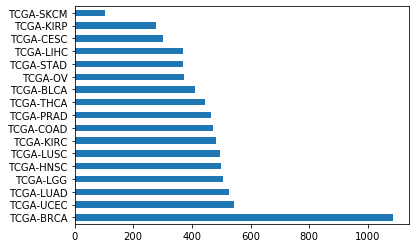

In [8]:
sample_sheet['Project ID'].value_counts()
# sample_sheet
tab = sample_sheet['Project ID'].value_counts()
tab.plot(kind='barh' )
tab

Here are the Cancer (types) Project codes:
```
BRCA	Breast invasive carcinoma
UCEC	Uterine Corpus Endometrial Carcinoma
LUAD	Lung adenocarcinoma
LGG 	Brain Lower Grade Glioma
HNSC	Head and Neck squamous cell carcinoma
LUSC	Lung squamous cell carcinoma
KIRP	Cervical Kidney renal papillary cell carcinoma
SKCM	Skin Cutaneous Melanoma      
KIRC	Kidney renal clear cell carcinoma
PRAD	Prostate adenocarcinoma
COAD	Colon adenocarcinoma
THCA	Thyroid carcinoma
BLCA	Bladder Urothelial Carcinoma
OV  	Ovarian serous cystadenocarcinoma
STAD	Stomach adenocarcinoma
LIHC	Liver hepatocellular carcinoma
CESC	Cervical squamous cell carcinoma and endocervical adenocarcinoma
```

## Check to see we have only tumor samples

In [9]:
sum(sample_sheet['Sample Type'] == 'Primary Tumor')
sample_sheet["Sample Type"].value_counts()

Primary Tumor    7731
Name: Sample Type, dtype: int64

## Retain only one replicate 

Create a **nr_sample_sheet**. I am following this step to reduce size of the data. 

In [10]:
# sample sheet no duplicates ; no replicates
sample_sheet_nr = sample_sheet.drop_duplicates(subset='Case ID', keep="first")

## Count the number of samples

In [11]:
sum(sample_sheet_nr['Project ID'].value_counts())

7654

##### To keep the file size within the github size limit (< 100 MB), I have decided to keep only the following three classes. 

```
TCGA-LGG   
TCGA-LUAD    
TCGA-THCA  
```
For research projects, you should retain all the available sites/types that have enough (example >= 300) samples. 

In [12]:
df = sample_sheet_nr.loc[sample_sheet_nr['Project ID'].isin(['TCGA-THCA','TCGA-LUAD','TCGA-LGG'])] 
df['Project ID'].value_counts()

TCGA-LUAD    508
TCGA-LGG     506
TCGA-THCA    445
Name: Project ID, dtype: int64

## Pick a stratified sample (of 50) from each class

Create a dataframe, df, that will contain a sample of 50 entries from group. For this exercise, we are restricting samples of size <= 50. ***Please note that the sample_size of 50 is chosen for the hands-on. For research projects, you should change this to a bigger number (ex 300).***

In [13]:
df = df.groupby('Project ID').apply(lambda s: s.sample(50))
num_of_classes = len(df['Project ID'].value_counts().index)
df = df.reset_index(drop = True)
print("Number of Cancer Types: ", num_of_classes)

Number of Cancer Types:  3


## Filter the manifest file (read in previously) to create a new manifest file  

Create a list to slice out a new GDC manifest file. Note this new manifest file will retain only the filtered (only for tumor; smaller sample size etc.) sample ids. This will then become the input for **GDC-toolkit** software (available in Biowulf). The output will be the corresponding RNAseq expression files. The expression files (one for each sample) have to be merged to create the final dataset. 

Here is the code to accomplish the tasks:

In [14]:
list = df['File Name'].values
print(len(list)) # should be 50 * 17 = 850 for this exercise

150


In [15]:
mgdc = gdc_manifest[gdc_manifest['filename'].isin(list)]
mgdc.head(3)

,id,filename,md5,size,state
111,036fbeb6-114a-4c5f-bc9b-d5317d4aef0f,ae3d90f2-e69b-4711-8e09-368c732cdc23.FPKM-UQ.t...,2c9b9fe7fa644cf5d0019b09fb6940a7,491052,validated
194,05faa6cb-6abe-4504-83a4-6121002ecfd6,702f5f23-47cb-49bd-ac6c-eb9eca14f028.FPKM-UQ.t...,7f83517ae452f992327cdf71a2e04318,535081,validated
463,0f74500f-c8b0-4478-8328-68d24789f629,db6a7442-904d-4c3d-b056-e787852785d2.FPKM-UQ.t...,14cdc0c1dac4148d23930bd8618f7eec,532886,validated


##  Write out the new mgdc dataframe 

mgdc filename, **mgdc_manifest_20200309_162520_50_estypes.txt** file. We previously executed the following code chunk to create a filtered manifest file, mgdc_manifest_20200309_162520_50_3stypes (available from the Data sub-folder). 

In [16]:
# We ran the following command to produce the output. No need to run it again.  
# mgdc.to_csv('Data/mgdc_manifest_20200309_162520_50_3stypes.txt', sep='\t', index=False)

## Use the Newly created manifest file to download/merge the expression data
I used NIH HPC for this step. For a sample size of 50 with 15 classes, you need decent memory/space. The gdc-rnaseq-tool (https://github.com/cpreid2/gdc-rnaseq-tool) will download (discussed in the introduction section) and merge the expression data.   

Here is the template slurm script for the task. Before you use the script, please make sure the slurm script memory 
is optimal for your query.
```
#!/bin/bash
#SBATCH --time=10:00:00
#SBATCH --job-name="GDC50"
#SBATCH --cpus-per-task=4
#SBATCH --mem=10g

echo "Job Started at `date`"
cd /data/ravichandrans/TC1/gdc-rnaseq-tool-50-3stypes
module load python/3.5
python3 gdc-rnaseq-tool.py mgdc_manifest_20200309_162520_50.txt --hugo

echo "Job Ended  at `date`"
```
Bring the merged dataframe, **Merged_FPKM-UQ-50_3stypes.tsv** and continue the analysis/modeling. For your convenience, I have completed this step and transfered the merged RNASeq expression file. The file, Merged_FPKM-UP-50_3stypes.tsvl, is available under Data forlder

## Read the merged expression file

In [17]:
df_FPKM_UQ = pd.read_csv("Data/Merged_FPKM-UQ-50_3stypes.tsv", low_memory=False, sep="\t")
print("Merged expression file")
df_FPKM_UQ.iloc[0:3, 0:6]

Merged expression file


,Unnamed: 0,gene_name,TCGA-05-4249-01A-01R-1107-07,TCGA-05-4389-01A-01R-1206-07,TCGA-05-4390-01A-02R-1755-07,TCGA-05-4417-01A-22R-1858-07
0,ENSG00000000003.13,TSPAN6,315981.544960,709336.737655,356558.245525,348652.528936
1,ENSG00000000005.5,TNMD,0.000000,217.936145,0.000000,1282.639158
2,ENSG00000000419.11,DPM1,542921.887819,646521.025015,771959.299629,373545.187633


## submitters_id mapping to project_id 

The merged expression file contains submitters_id_list but doesnt include project_id. 
Submitters_id_list can be searched in GDC manually to find the relevant project_id. I have completed the steps and 
made the files available. 

In [18]:
cols = df_FPKM_UQ.columns[2:].values.tolist()
print("Length of cols variable: ",len(cols))
print("First few Submitters_ID", cols[1:4])

# DONT UNCOMMENT THE FOLLOWING LINES
# DONT DELETE THIS IS USED TO WRITE OUT THE FILE, submitters_id_list.txt
# this file was searched to find the project_id list from GDC website
# cols
# type(cols)
# with open('Data/submitters_id_list_50.txt', 'w') as f:
#     for item in cols:
#         f.write("%s\n" % item)           

Length of cols variable:  150
First few Submitters_ID ['TCGA-05-4389-01A-01R-1206-07', 'TCGA-05-4390-01A-02R-1755-07', 'TCGA-05-4417-01A-22R-1858-07']


## Map "submitters_ID" to "Project_ID"
This step was done using GDC website.

In [19]:
submitters_id_to_project_id = pd.read_csv("Data/submitters_id_to_project_id_50.tsv", low_memory=False, sep="\t")
print("Here is the Submitters_ID to Project_ID mapping list:")
print(submitters_id_to_project_id.iloc[0:4,0:6])

Here is the Submitters_ID to Project_ID mapping list:
            submittedAliquot ID  mappedCaseId mappedProject
0  TCGA-05-4249-01A-01R-1107-07  TCGA-05-4249     TCGA-LUAD
1  TCGA-05-4389-01A-01R-1206-07  TCGA-05-4389     TCGA-LUAD
2  TCGA-05-4390-01A-02R-1755-07  TCGA-05-4390     TCGA-LUAD
3  TCGA-05-4417-01A-22R-1858-07  TCGA-05-4417     TCGA-LUAD


In [20]:
submitters_id_to_project_id.columns
submitters_id_to_project_id.mappedProject.value_counts()

TCGA-THCA    50
TCGA-LUAD    50
TCGA-LGG     50
Name: mappedProject, dtype: int64

In [21]:
# Transpose the data
dft_FPKM_UQ = df_FPKM_UQ.T
# remove the two two rows and save the output
dftm_FPKM_UQ = dft_FPKM_UQ.drop(dft_FPKM_UQ.index[0:2], axis=0)

#### Extract the Submitter ID from the index and attach it as a column also called Submitter ID

In [22]:
dftm_FPKM_UQ['submitter_id'] = dftm_FPKM_UQ.index

# reset the index
dftm_FPKM_UQ = dftm_FPKM_UQ.reset_index(drop=True)
sid_list = submitters_id_to_project_id['submittedAliquot ID'].values.tolist()

dftm_FPKM_UQ['Project_id'] = ' '
for idx, val in dftm_FPKM_UQ['submitter_id'].items():
    temp_sid = sid_list.index(val)
    dftm_FPKM_UQ['Project_id'][idx] = submitters_id_to_project_id['mappedProject'][temp_sid]
    
dftm_FPKM_UQ.drop(['submitter_id'], axis = 1,  inplace=True)

## Final check before moving on

In [23]:
print(dftm_FPKM_UQ.Project_id.value_counts())
dftm_FPKM_UQ.iloc[0:3,0:15]

TCGA-THCA    50
TCGA-LUAD    50
TCGA-LGG     50
Name: Project_id, dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,315982,0,542922,89170.7,28230.6,113983,109903,416956,60672.3,595059,31576.1,163079,172186,260577,241914
1,709337,217.936,646521,65658.8,50041.3,162106,122042,1.47989e+06,700386,413208,17232.6,72645.5,196941,376150,482183
2,356558,0,771959,45730.5,63370.8,109248,78999.9,849467,444175,240654,15300.5,60648,192379,134305,143576


## Convert outcome into numerical quantity

In [24]:
# multiple options for accomplishing this task
le = preprocessing.LabelEncoder()

# Create a label (category) encoder object
dftm_FPKM_UQ['Project_id'] = le.fit_transform(dftm_FPKM_UQ.Project_id.values)

### These are the coded variables and their mappings

In [25]:
num = np.arange(0,len(le.classes_),1)
print("codenum", num)

print("labels: ", le.inverse_transform(num))

codenum [0 1 2]
labels:  ['TCGA-LGG' 'TCGA-LUAD' 'TCGA-THCA']


## Split the features and outcome variables

In [26]:
# Use to_categorical on your labels
features = dftm_FPKM_UQ.drop(['Project_id'], axis=1)
outcome = dftm_FPKM_UQ.Project_id
outcome

0      1
1      1
2      1
3      1
4      1
      ..
145    0
146    0
147    0
148    0
149    0
Name: Project_id, Length: 150, dtype: int32

## Scaling procedure for the features

FPKM_UQ to TPM

$$ \textrm{TPM}_{i}  = \bigg( \frac{\textrm{FPKM}} {\sum_{j} \textrm{FPKM}_{j}} \bigg) \times {10^6} $$

$$ \textrm{TPM}_{i} = log_{10}(\textrm{TPM}_{i}) $$

In [27]:
sfeatures = features.div(features.sum(axis=1), axis=0)
sfeatures = sfeatures * 1000000

sfeatures1 = sfeatures.astype(np.float64).apply(np.log10)
sfeatures1[sfeatures1 < 0] = 0

## Let us look at the distribution of few selected samples

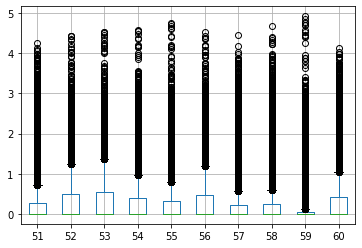

In [28]:
df_temp = sfeatures1.iloc[51:61, :]
df_temp.T.boxplot()

## Save the files for later use

In [ ]:
sfeatures1.to_csv('Data/TC1-data3stypes.tsv', sep='\t', index=False)
outcome.to_csv('Data/TC1-outcome-data3stypes.tsv', sep='\t', index=False, header = False)

## Part-II: Convolutional Neural Network

* Splitting the data
* Model preparation 
* Training/Testing 
* Exporting the Weights 
* inference option

**Acknowledgements:** Drs. George Zaki, Andrew Weisman. I would like to thank FNLCR BIDS colleagues for reviewing the materials. This is a follow-up to the NCI-DOE Pilot1 benchmark 